In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =6.375563e-24

nband = 80

ng =9

ng_adju = (/ 0 , 0 /) 

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 1000

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 540

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.65 , 1.6,
     &     1.85/

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

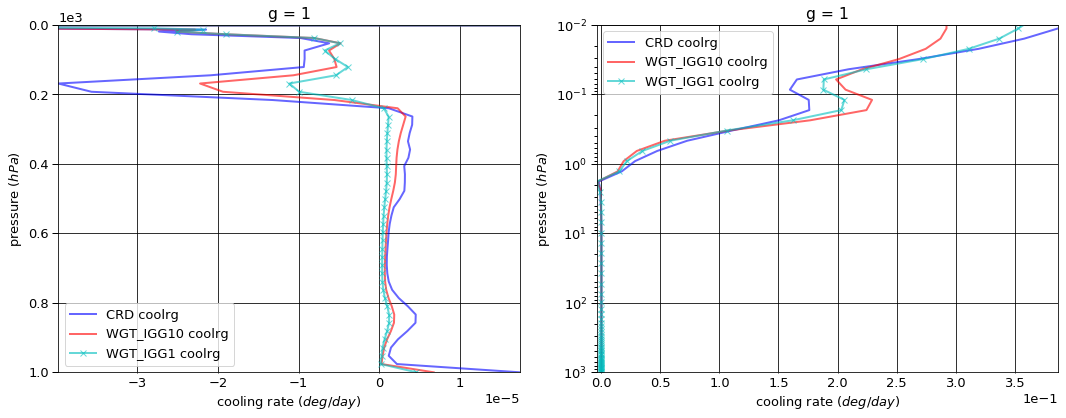

# Figure: cooling rate g-group 2

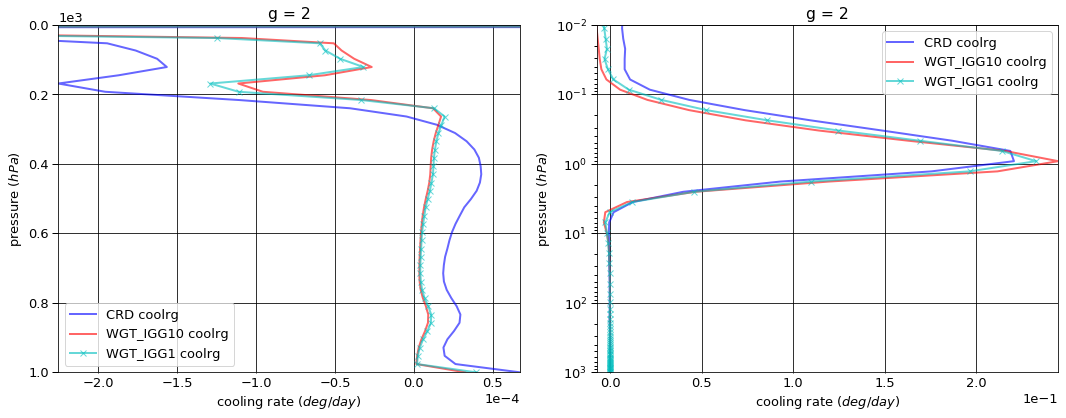

# Figure: cooling rate g-group 3

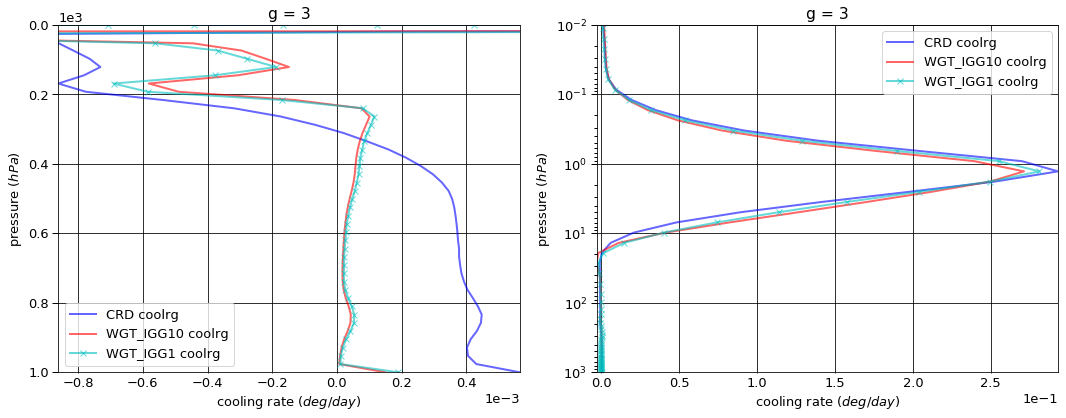

# Figure: cooling rate g-group 4

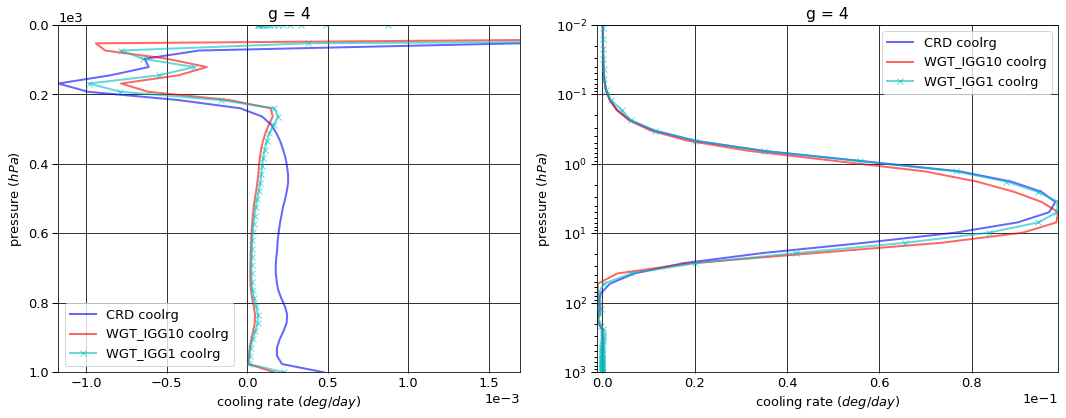

# Figure: cooling rate g-group 5

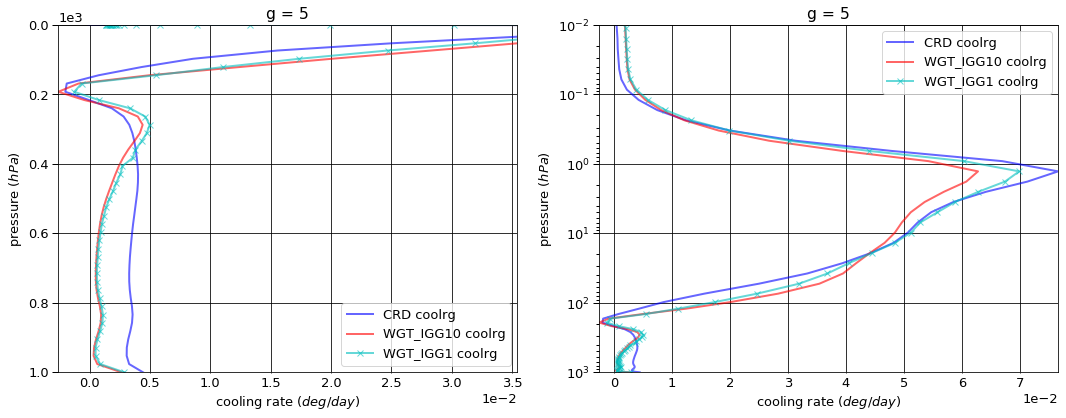

# Figure: cooling rate g-group 6

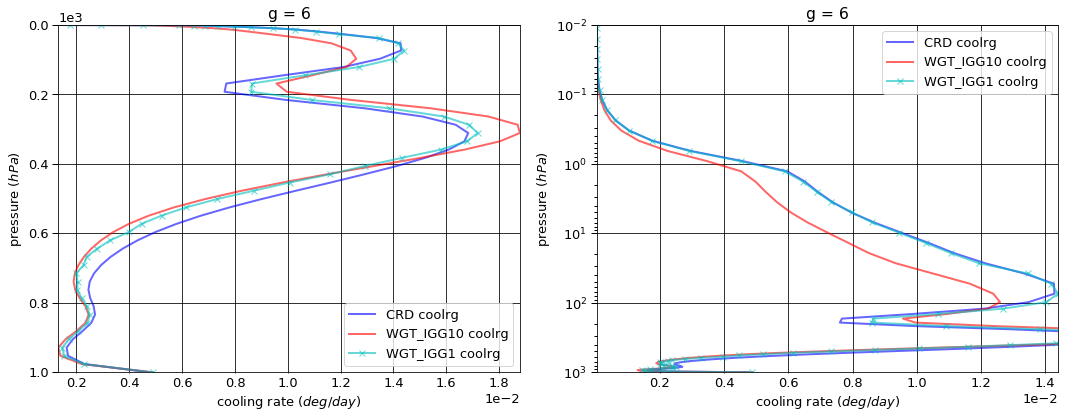

# Figure: cooling rate g-group 7

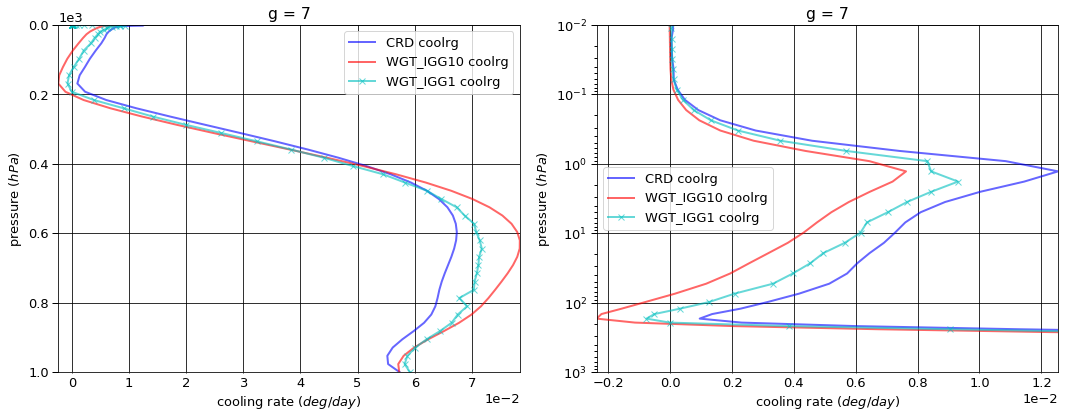

# Figure: cooling rate g-group 8

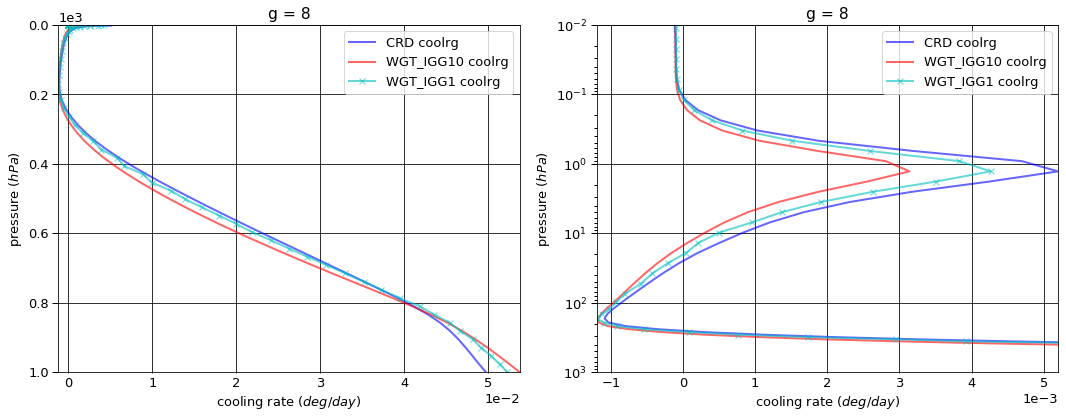

# Figure: cooling rate g-group 9

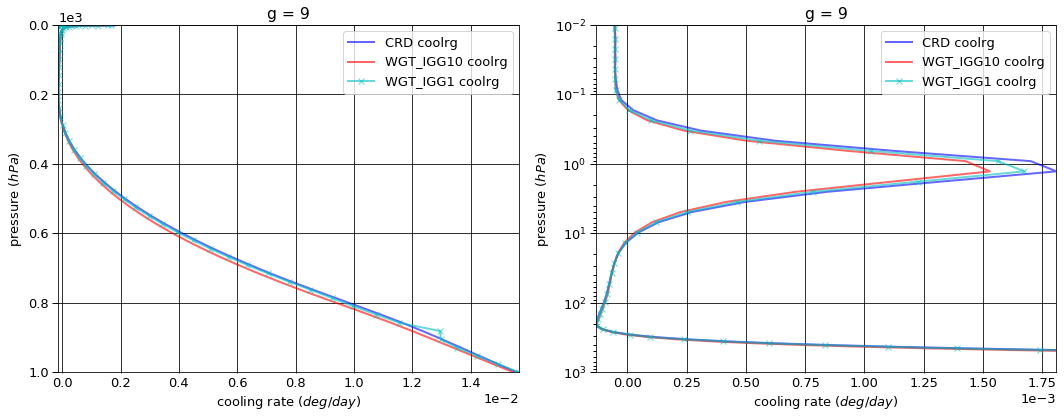

# Figure: cooling rate g-group total

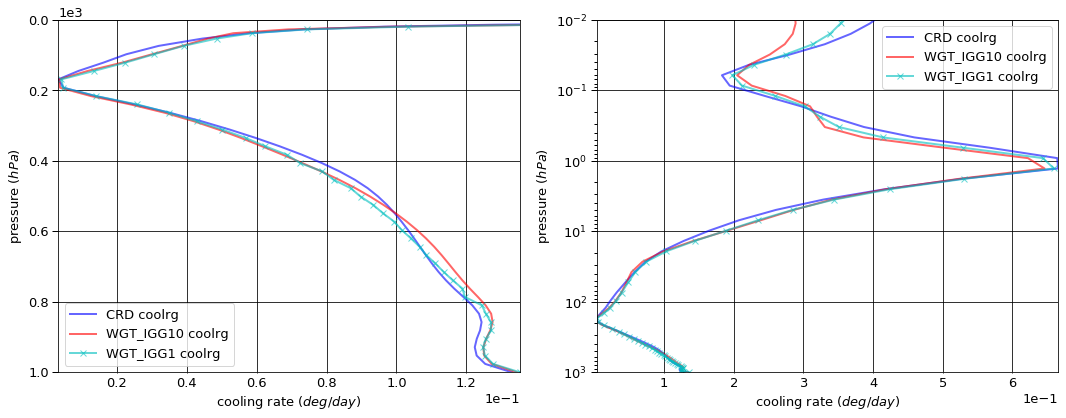

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011562  0.000000  -0.011562
  1013.0   76     -0.026654  0.026599  -0.000055
2 0.0      1      -0.039738  0.000000  -0.039738
  1013.0   76     -0.059196  0.058856  -0.000340
3 0.0      1      -0.156082  0.000000  -0.156082
  1013.0   76     -0.259090  0.247160  -0.011929
4 0.0      1      -0.210322  0.000000  -0.210322
  1013.0   76     -0.447316  0.443233  -0.004083
5 0.0      1      -0.796980  0.000000  -0.796980
  1013.0   76     -1.712117  1.589841  -0.122276
6 0.0      1      -0.995692  0.000000  -0.995692
  1013.0   76     -2.342321  2.319386  -0.022934
7 0.0      1      -6.512760  0.000000  -6.512760
  1013.0   76     -9.718741  8.431676  -1.287065
8 0.0      1      -7.571848  0.000000  -7.571848
  1013.0   76     -8.268252  2.996945  -5.271308
9 0.0      1     -13.292951  0.000000 -13.292951
  1013.0   76    -13.401723  0.651479 -12.750244


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011012  0.000000  -0.011012
  1013.0   76     -0.026654  0.026635  -0.000019
2 0.0      1      -0.041466  0.000000  -0.041466
  1013.0   76     -0.059196  0.059106  -0.000090
3 0.0      1      -0.154693  0.000000  -0.154693
  1013.0   76     -0.259090  0.258672  -0.000418
4 0.0      1      -0.211247  0.000000  -0.211247
  1013.0   76     -0.447316  0.446845  -0.000471
5 0.0      1      -0.631585  0.000000  -0.631585
  1013.0   76     -1.712117  1.703209  -0.008907
6 0.0      1      -0.952116  0.000000  -0.952116
  1013.0   76     -2.342321  2.321381  -0.020939
7 0.0      1      -6.455987  0.000000  -6.455987
  1013.0   76     -9.718741  8.799704  -0.919037
8 0.0      1      -7.659215  0.000000  -7.659215
  1013.0   76     -8.268252  2.826032  -5.442221
9 0.0      1     -13.301689  0.000000 -13.301689
  1013.0   76    -13.401723  0.619985 -12.781738


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011070  0.000000  -0.011070
  1013.0   76     -0.026654  0.026641  -0.000013
2 0.0      1      -0.040849  0.000000  -0.040849
  1013.0   76     -0.059196  0.059086  -0.000110
3 0.0      1      -0.153469  0.000000  -0.153469
  1013.0   76     -0.259090  0.258557  -0.000533
4 0.0      1      -0.210152  0.000000  -0.210152
  1013.0   76     -0.447316  0.446684  -0.000632
5 0.0      1      -0.641364  0.000000  -0.641364
  1013.0   76     -1.712117  1.701456  -0.010661
6 0.0      1      -0.958038  0.000000  -0.958038
  1013.0   76     -2.342321  2.320329  -0.021991
7 0.0      1      -6.481298  0.000000  -6.481298
  1013.0   76     -9.718741  8.585297  -1.133444
8 0.0      1      -7.590394  0.000000  -7.590394
  1013.0   76     -8.268252  2.981602  -5.286651
9 0.0      1     -13.296138  0.000000 -13.296138
  1013.0   76    -13.401723  0.644334 -12.757389


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      5.499850e-04  0.000000  0.000550
  1013.0   76    -3.469447e-18  0.000036  0.000036
2 0.0      1     -1.727571e-03  0.000000 -0.001728
  1013.0   76    -6.938894e-18  0.000250  0.000250
3 0.0      1      1.389320e-03  0.000000  0.001389
  1013.0   76     0.000000e+00  0.011511  0.011511
4 0.0      1     -9.251100e-04  0.000000 -0.000925
  1013.0   76     0.000000e+00  0.003612  0.003612
5 0.0      1      1.653953e-01  0.000000  0.165395
  1013.0   76     0.000000e+00  0.113369  0.113369
6 0.0      1      4.357619e-02  0.000000  0.043576
  1013.0   76     0.000000e+00  0.001995  0.001995
7 0.0      1      5.677320e-02  0.000000  0.056773
  1013.0   76     0.000000e+00  0.368027  0.368027
8 0.0      1     -8.736760e-02  0.000000 -0.087368
  1013.0   76     0.000000e+00 -0.170913 -0.170913
9 0.0      1     -8.738000e-03  0.000000 -0.008738
  1013.0   76     0.000000e+00 -0.031493 -0.031494


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.920440e-04  0.000000  0.000492
  1013.0   76    -3.469447e-18  0.000042  0.000042
2 0.0      1     -1.110310e-03  0.000000 -0.001110
  1013.0   76    -6.938894e-18  0.000231  0.000231
3 0.0      1      2.613430e-03  0.000000  0.002613
  1013.0   76     0.000000e+00  0.011396  0.011396
4 0.0      1      1.701000e-04  0.000000  0.000170
  1013.0   76     0.000000e+00  0.003451  0.003451
5 0.0      1      1.556166e-01  0.000000  0.155617
  1013.0   76     0.000000e+00  0.111615  0.111615
6 0.0      1      3.765372e-02  0.000000  0.037654
  1013.0   76     0.000000e+00  0.000943  0.000943
7 0.0      1      3.146220e-02  0.000000  0.031462
  1013.0   76     0.000000e+00  0.153621  0.153621
8 0.0      1     -1.854660e-02  0.000000 -0.018547
  1013.0   76     0.000000e+00 -0.015343 -0.015343
9 0.0      1     -3.187000e-03  0.000000 -0.003187
  1013.0   76     0.000000e+00 -0.007145 -0.007145

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.396413
  1001.112500 75     0.000017
2 0.000312    1     -0.001576
  1001.112500 75     0.000067
3 0.000312    1     -0.001069
  1001.112500 75     0.000566
4 0.000312    1      0.000053
  1001.112500 75     0.000476
5 0.000312    1     -0.000082
  1001.112500 75     0.004432
6 0.000312    1      0.000027
  1001.112500 75     0.004766
7 0.000312    1     -0.000062
  1001.112500 75     0.057384
8 0.000312    1     -0.000165
  1001.112500 75     0.049739
9 0.000312    1     -0.000048
  1001.112500 75     0.015586


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.232798
  1001.112500 75     0.000007
2 0.000312    1     -0.011848
  1001.112500 75     0.000032
3 0.000312    1     -0.000275
  1001.112500 75     0.000150
4 0.000312    1      0.000082
  1001.112500 75     0.000170
5 0.000312    1      0.001337
  1001.112500 75     0.002640
6 0.000312    1      0.000022
  1001.112500 75     0.004890
7 0.000312    1     -0.000046
  1001.112500 75     0.057289
8 0.000312    1     -0.000106
  1001.112500 75     0.053760
9 0.000312    1     -0.000048
  1001.112500 75     0.015476


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.330579
  1001.112500 75     0.000005
2 0.000312    1     -0.009289
  1001.112500 75     0.000039
3 0.000312    1     -0.001279
  1001.112500 75     0.000190
4 0.000312    1      0.000065
  1001.112500 75     0.000228
5 0.000312    1      0.001358
  1001.112500 75     0.002879
6 0.000312    1      0.000031
  1001.112500 75     0.004879
7 0.000312    1     -0.000006
  1001.112500 75     0.059171
8 0.000312    1     -0.000105
  1001.112500 75     0.052279
9 0.000312    1     -0.000050
  1001.112500 75     0.015661


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.636143e-01
  1001.112500 75    -1.066407e-05
2 0.000312    1     -1.027193e-02
  1001.112500 75    -3.462674e-05
3 0.000312    1      7.938642e-04
  1001.112500 75    -4.152054e-04
4 0.000312    1      2.917608e-05
  1001.112500 75    -3.063004e-04
5 0.000312    1      1.419434e-03
  1001.112500 75    -1.791743e-03
6 0.000312    1     -4.418367e-06
  1001.112500 75     1.247556e-04
7 0.000312    1      1.618745e-05
  1001.112500 75    -9.525300e-05
8 0.000312    1      5.946724e-05
  1001.112500 75     4.020297e-03
9 0.000312    1      4.147600e-08
  1001.112500 75    -1.097190e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.065834
  1001.112500 75    -0.000013
2 0.000312    1     -0.007713
  1001.112500 75    -0.000028
3 0.000312    1     -0.000210
  1001.112500 75    -0.000376
4 0.000312    1      0.000012
  1001.112500 75    -0.000248
5 0.000312    1      0.001440
  1001.112500 75    -0.001553
6 0.000312    1      0.000004
  1001.112500 75     0.000114
7 0.000312    1      0.000056
  1001.112500 75     0.001787
8 0.000312    1      0.000061
  1001.112500 75     0.002540
9 0.000312    1     -0.000002
  1001.112500 75     0.000075

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.587936,0.000000,-29.587936
1013.0,76,-36.235408,16.765174,-19.470233



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.419010,0.000000,-29.41901
1013.0,76,-36.235408,17.061569,-19.17384



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.382772,0.000000,-29.382772
1013.0,76,-36.235408,17.023985,-19.211423



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.168926,0.000000,0.168926
1013.0,76,0.000000,0.296394,0.296394



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.205164,0.000000,0.205164
1013.0,76,0.000000,0.258811,0.258811


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.393490
1001.112500,75,0.133033



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.221918
1001.112500,75,0.134414



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.321303
1001.112500,75,0.135332



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.171572
1001.112500,75,0.001382



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.072187
1001.112500,75,0.002299


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000737,0.000718
2,0.001638,0.001596
3,0.007162,0.007011
4,0.012375,0.012056
5,0.047313,0.046418
6,0.064750,0.063288
7,0.268363,0.263841
8,0.227887,0.228856
9,0.369775,0.376216


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.344054e-19
2,2.155925e-20
3,1.982895e-21
4,1.784805e-21
5,1.648433e-22
6,7.248533e-22
7,6.798069e-23
8,6.375599e-24
9,1.011343e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.344054e-19,NaN,0.000737,0.000718,0.000737,0.000718,1.0
2,2.155925e-20,0.091974,0.001638,0.001596,0.002375,0.002314,1.0
3,1.982895e-21,0.091974,0.007162,0.007011,0.009537,0.009325,1.0
4,1.784805e-21,0.900100,0.012375,0.012056,0.021913,0.021381,10.0
5,1.648433e-22,0.092359,0.047313,0.046418,0.069225,0.067799,10.0
6,7.248533e-22,4.397225,0.064750,0.063288,0.133975,0.131087,500.0
7,6.798069e-23,0.093785,0.268363,0.263841,0.402338,0.394928,500.0
8,6.375599e-24,0.093785,0.227887,0.228856,0.630225,0.623784,500.0
9,1.011343e-25,0.015863,0.369775,0.376216,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
